In [49]:
## Standard libraries
import os
import numpy as np
import random
import json
from PIL import Image
from collections import defaultdict
from statistics import mean, stdev
from copy import deepcopy

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

## tqdm for loading bars
from tqdm.auto import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

## Torchvision
import torchvision
from torchvision.datasets import CIFAR100, SVHN
import torchvision.transforms as transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


In [50]:
CIFAR_train_set = CIFAR100(root="../data", train=True, download=True, transform=transforms.ToTensor())
CIFAR_test_set = CIFAR100(root="../data", train=False, download=True, transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [3]:
CIFAR_all_images = np.concatenate([CIFAR_train_set.data, CIFAR_test_set.data], axis=0)
CIFAR_all_targets = torch.LongTensor(CIFAR_train_set.targets + CIFAR_test_set.targets)
print(CIFAR_all_targets)

tensor([19, 29,  0,  ..., 51, 42, 70])


In [47]:
print(CIFAR_all_images[0].shape)

(32, 32, 3)


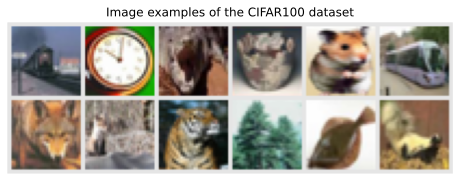

In [4]:
NUM_IMAGES = 12
CIFAR_images = torch.stack([CIFAR_train_set[np.random.randint(len(CIFAR_train_set))][0] for idx in range(NUM_IMAGES)], dim=0)
img_grid = torchvision.utils.make_grid(CIFAR_images, nrow=6, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("Image examples of the CIFAR100 dataset")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

In [90]:
print(CIFAR_all_images[0])

[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [195 205 193]
  [212 224 204]
  [182 194 167]]

 [[255 255 255]
  [254 254 254]
  [254 254 254]
  ...
  [170 176 150]
  [161 168 130]
  [146 154 113]]

 [[255 255 255]
  [254 254 254]
  [255 255 255]
  ...
  [189 199 169]
  [166 178 130]
  [121 133  87]]

 ...

 [[148 185  79]
  [142 182  57]
  [140 179  60]
  ...
  [ 30  17   1]
  [ 65  62  15]
  [ 76  77  20]]

 [[122 157  66]
  [120 155  58]
  [126 160  71]
  ...
  [ 22  16   3]
  [ 97 112  56]
  [141 161  87]]

 [[ 87 122  41]
  [ 88 122  39]
  [101 134  56]
  ...
  [ 34  36  10]
  [105 133  59]
  [138 173  79]]]


In [5]:
torch.manual_seed(0)           # Set seed for reproducibility
classes = torch.randperm(100)  # Returns random permutation of numbers 0 to 99
train_classes, test_classes, val_classes = classes[:64], classes[64:80], classes[80:] #similar to miniImageNet

In [6]:
idx_to_class = {val: key for key, val in CIFAR_train_set.class_to_idx.items()}
print("Test classes:", [idx_to_class[c.item()] for c in val_classes])
print("Val classes:", [idx_to_class[c.item()] for c in test_classes])

Test classes: ['caterpillar', 'castle', 'skunk', 'ray', 'bus', 'motorcycle', 'keyboard', 'chimpanzee', 'possum', 'tiger', 'kangaroo', 'crocodile', 'butterfly', 'shark', 'forest', 'pickup_truck', 'telephone', 'lion', 'worm', 'mushroom']
Val classes: ['flatfish', 'fox', 'boy', 'apple', 'clock', 'bridge', 'television', 'mouse', 'couch', 'maple_tree', 'hamster', 'willow_tree', 'bottle', 'sweet_pepper', 'poppy', 'table']


#### Create a task from dataset randomly

In [77]:
def createSplits(all_imgs, all_labels, k_shot):#, train_classes, test_classes, val_classes):
    """
    Inputs:
        imgs - Numpy array of shape [N,32,32,3] containing all images.
        targets - PyTorch array of shape [N] containing all labels.
        k-shot - 
        
    """
        
    classes = torch.unique(all_labels).tolist()
    data_by_classes = []
    
    #organize by classes
    for class_ in classes:
        
        holder_array = []
        if(class_ % 10 == 0): print(class_)
        idx_array = [i for i, x in enumerate(all_labels) if x == class_]
#         print(idx_array)
        labels_for_class = [all_labels[i] for i in idx_array]
        img_for_class = [all_imgs[i] for i in idx_array]
#         print(len(img_for_class))
        data_by_classes.append([img_for_class,labels_for_class])
            
    
    #create tasks for train, test, and val
    #train_classes may need to come from a split folder
    
    train_by_class = []
    test_by_class = []
    val_by_class = []
    train_by_class_q = []
    test_by_class_q = []
    val_by_class_q = []
    
    
    random.shuffle(classes)
    classes_for_tasks = classes
    print(classes_for_tasks)
    
    #To create Query Set 
    

    train_classes, test_classes, val_classes = classes_for_tasks[:75], classes_for_tasks[75:90], classes_for_tasks[90:]
    
    for data_by_class in data_by_classes:
        
        class_in_set = data_by_class[1][0]
        if(class_in_set in train_classes):
            k_shot_indicies = random.sample(range(0,len(data_by_class[0])-k_shot-1), k_shot)
            class_train_data = [[data_by_class[0][i], data_by_class[1][i]] for i in k_shot_indicies]
            query_set_class_train = [[data_by_class[0][i], data_by_class[1][-i]] for i in range(1,k_shot+1)]
            train_by_class_q.append(query_set_class_train)
            train_by_class.append(class_train_data)
            
        elif(class_in_set in test_classes):
            
            k_shot_indicies = random.sample(range(0,len(data_by_class[0])-k_shot-1), k_shot)
            class_test_data = [[data_by_class[0][i], data_by_class[1][i]] for i in k_shot_indicies]
            query_set_class_test = [[data_by_class[0][-i], data_by_class[1][-i]] for i in range(1,k_shot+1)]
            test_by_class_q.append(query_set_class_test)
            test_by_class.append(class_test_data)
            
        elif(class_in_set in val_classes):
            
            k_shot_indicies = random.sample(range(0,len(data_by_class[0])-k_shot-1), k_shot)
            class_val_data = [[data_by_class[0][i], data_by_class[1][i]] for i in k_shot_indicies]
            query_set_class_val = [[data_by_class[0][-i], data_by_class[1][-i]] for i in range(1,k_shot+1)]
            val_by_class_q.append(query_set_class_val)
            val_by_class.append(class_val_data)
    
    return train_by_class, test_by_class, val_by_class,train_by_class_q, test_by_class_q, val_by_class_q

train_by_class, test_by_class, val_by_class,train_by_class_q, test_by_class_q, val_by_class_q = createSplits(CIFAR_all_images, CIFAR_all_targets, 5)

0
10
20
30
40
50
60
70
80
90
[0, 40, 53, 90, 19, 14, 71, 81, 47, 73, 29, 80, 26, 11, 74, 3, 63, 4, 59, 46, 39, 50, 95, 68, 57, 83, 33, 87, 9, 13, 67, 25, 44, 58, 55, 79, 75, 99, 10, 56, 51, 7, 69, 64, 24, 48, 35, 2, 5, 15, 8, 17, 93, 49, 31, 70, 21, 42, 94, 60, 38, 27, 97, 22, 1, 85, 76, 16, 62, 12, 54, 45, 32, 20, 65, 30, 72, 18, 89, 66, 96, 37, 28, 84, 23, 92, 88, 86, 91, 78, 36, 43, 41, 34, 98, 82, 77, 61, 6, 52]


[[[198 178 161]
  [169 139 118]
  [145 115  96]
  ...
  [223  66  81]
  [150  47  57]
  [ 84  25  29]]

 [[189 159 138]
  [169 137 115]
  [128  99  81]
  ...
  [252  68  83]
  [249  68  84]
  [232  60  75]]

 [[187 155 131]
  [139 110  91]
  [109  82  68]
  ...
  [249  59  70]
  [250  61  73]
  [250  58  70]]

 ...

 [[ 21  19  18]
  [ 91  88  81]
  [214 213 189]
  ...
  [190 105  71]
  [189 106  74]
  [148  84  61]]

 [[ 87  65  42]
  [ 15  14  14]
  [135 133 111]
  ...
  [175  96  68]
  [126  60  39]
  [ 64  36  29]]

 [[192 156 119]
  [ 46  44  42]
  [ 78  76  66]
  ...
  [123  59  40]
  [ 47  24  20]
  [ 45  41  41]]]


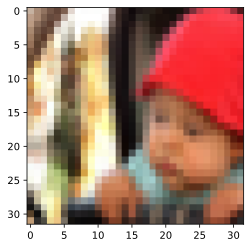

In [103]:
image_data = train_by_class[2][0][0]
print(image_data)
plt.imshow(image_data)

In [79]:
def createTasks(training_data_ss, training_data_q, n_way, k_shots):
    
    no_tasks = len(training_data_ss)/n_way
    
    classes = [element[0][1] for element in training_data_ss]

    c = list(zip(training_data_ss, training_data_q))

    random.shuffle(c)

    training_data_ss, training_data_q = zip(*c)

    tasks = []

    for i in range(int(len(classes)/n_way)):
        task_dic = {}
        task_holder_ss = []
        task_holder_q = []
        if(n_way*(i+1)-1 < len(classes)):   
            for j in range(n_way):
                task_holder_ss= [*task_holder_ss, *training_data_ss[n_way*i+j]]
                task_holder_q= [*task_holder_ss, *training_data_q[n_way*i+j]]
        else:
            last_index_p1 = len(classes)
            
            for j in range(n_way*(i), last_index_p1):
                task_holder_ss= [*task_holder_ss, *training_data_ss[n_way*i+j]]
                task_holder_q= [*task_holder_ss, *training_data_q[n_way*i+j]]
        task_dic['support'] = task_holder_ss
        task_dic['query'] = task_holder_q[:k_shots]
        
        tasks.append(task_dic)
    
    return tasks

train_tasks = createTasks(train_by_class, train_by_class_q, 5, 5)
test_tasks = createTasks(test_by_class, test_by_class_q, 5, 5)
val_tasks = createTasks(val_by_class, val_by_class_q, 5, 5)

In [100]:
print(train_tasks[0]['support'][0])

[array([[[147, 181, 195],
        [136, 172, 196],
        [137, 178, 200],
        ...,
        [142, 176, 199],
        [132, 167, 190],
        [124, 151, 167]],

       [[ 89, 139, 165],
        [ 77, 140, 171],
        [ 85, 156, 183],
        ...,
        [ 71, 135, 170],
        [ 58, 120, 151],
        [ 58, 102, 120]],

       [[ 99, 147, 161],
        [ 76, 142, 159],
        [ 78, 149, 164],
        ...,
        [ 70, 149, 173],
        [ 63, 144, 160],
        [ 72, 129, 132]],

       ...,

       [[ 88, 115, 123],
        [ 59, 108, 127],
        [ 67, 111, 139],
        ...,
        [ 61,  82, 107],
        [ 53,  85, 116],
        [ 54,  77,  97]],

       [[ 93, 126, 141],
        [ 68, 120, 148],
        [ 66, 119, 154],
        ...,
        [ 67,  99, 133],
        [ 67, 102, 137],
        [ 62,  86, 108]],

       [[ 98, 131, 148],
        [ 80, 123, 148],
        [ 81, 124, 150],
        ...,
        [ 79, 108, 140],
        [ 77, 107, 139],
        [ 79, 103, 124]

[[[147 181 195]
  [136 172 196]
  [137 178 200]
  ...
  [142 176 199]
  [132 167 190]
  [124 151 167]]

 [[ 89 139 165]
  [ 77 140 171]
  [ 85 156 183]
  ...
  [ 71 135 170]
  [ 58 120 151]
  [ 58 102 120]]

 [[ 99 147 161]
  [ 76 142 159]
  [ 78 149 164]
  ...
  [ 70 149 173]
  [ 63 144 160]
  [ 72 129 132]]

 ...

 [[ 88 115 123]
  [ 59 108 127]
  [ 67 111 139]
  ...
  [ 61  82 107]
  [ 53  85 116]
  [ 54  77  97]]

 [[ 93 126 141]
  [ 68 120 148]
  [ 66 119 154]
  ...
  [ 67  99 133]
  [ 67 102 137]
  [ 62  86 108]]

 [[ 98 131 148]
  [ 80 123 148]
  [ 81 124 150]
  ...
  [ 79 108 140]
  [ 77 107 139]
  [ 79 103 124]]]


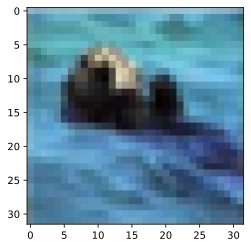

In [106]:
image_data = train_tasks[0]['support'][0][0]
print(image_data)
plt.imshow(image_data)

In [9]:
import  torch
from    torch import nn
from    torch.nn import functional as F
import  numpy as np


# """
# Taken From:

# @misc{MAML_Pytorch,
#   author = {Liangqu Long},
#   title = {MAML-Pytorch Implementation},
#   year = {2018},
#   publisher = {GitHub},
#   journal = {GitHub repository},
#   howpublished = {\url{https://github.com/dragen1860/MAML-Pytorch}},
#   commit = {master}
# }

# """


class Learner(nn.Module):

    def __init__(self, config, imgc, imgsz):
        """
        :param config: network config file, type:list of (string, list)
        :param imgc: 1 or 3
        :param imgsz:  28 or 84
        """
        super(Learner, self).__init__()


        self.config = config

        # this dict contains all tensors needed to be optimized
        self.vars = nn.ParameterList()
        # running_mean and running_var
        self.vars_bn = nn.ParameterList()

        for i, (name, param) in enumerate(self.config):
            if name is 'conv2d':
                # [ch_out, ch_in, kernelsz, kernelsz]
                w = nn.Parameter(torch.ones(*param[:4]))
                # gain=1 according to cbfin's implementation
                torch.nn.init.kaiming_normal_(w)
                self.vars.append(w)
                # [ch_out]
                self.vars.append(nn.Parameter(torch.zeros(param[0])))

            elif name is 'convt2d':
                # [ch_in, ch_out, kernelsz, kernelsz, stride, padding]
                w = nn.Parameter(torch.ones(*param[:4]))
                # gain=1 according to cbfin's implementation
                torch.nn.init.kaiming_normal_(w)
                self.vars.append(w)
                # [ch_in, ch_out]
                self.vars.append(nn.Parameter(torch.zeros(param[1])))

            elif name is 'linear':
                # [ch_out, ch_in]
                w = nn.Parameter(torch.ones(*param))
                # gain=1 according to cbfinn's implementation
                torch.nn.init.kaiming_normal_(w)
                self.vars.append(w)
                # [ch_out]
                self.vars.append(nn.Parameter(torch.zeros(param[0])))

            elif name is 'bn':
                # [ch_out]
                w = nn.Parameter(torch.ones(param[0]))
                self.vars.append(w)
                # [ch_out]
                self.vars.append(nn.Parameter(torch.zeros(param[0])))

                # must set requires_grad=False
                running_mean = nn.Parameter(torch.zeros(param[0]), requires_grad=False)
                running_var = nn.Parameter(torch.ones(param[0]), requires_grad=False)
                self.vars_bn.extend([running_mean, running_var])


            elif name in ['tanh', 'relu', 'upsample', 'avg_pool2d', 'max_pool2d',
                          'flatten', 'reshape', 'leakyrelu', 'sigmoid']:
                continue
            else:
                raise NotImplementedError






    def extra_repr(self):
        info = ''

        for name, param in self.config:
            if name is 'conv2d':
                tmp = 'conv2d:(ch_in:%d, ch_out:%d, k:%dx%d, stride:%d, padding:%d)'\
                      %(param[1], param[0], param[2], param[3], param[4], param[5],)
                info += tmp + '\n'

            elif name is 'convt2d':
                tmp = 'convTranspose2d:(ch_in:%d, ch_out:%d, k:%dx%d, stride:%d, padding:%d)'\
                      %(param[0], param[1], param[2], param[3], param[4], param[5],)
                info += tmp + '\n'

            elif name is 'linear':
                tmp = 'linear:(in:%d, out:%d)'%(param[1], param[0])
                info += tmp + '\n'

            elif name is 'leakyrelu':
                tmp = 'leakyrelu:(slope:%f)'%(param[0])
                info += tmp + '\n'


            elif name is 'avg_pool2d':
                tmp = 'avg_pool2d:(k:%d, stride:%d, padding:%d)'%(param[0], param[1], param[2])
                info += tmp + '\n'
            elif name is 'max_pool2d':
                tmp = 'max_pool2d:(k:%d, stride:%d, padding:%d)'%(param[0], param[1], param[2])
                info += tmp + '\n'
            elif name in ['flatten', 'tanh', 'relu', 'upsample', 'reshape', 'sigmoid', 'use_logits', 'bn']:
                tmp = name + ':' + str(tuple(param))
                info += tmp + '\n'
            else:
                raise NotImplementedError

        return info



    def forward(self, x, vars=None, bn_training=True):
        """
        This function can be called by finetunning, however, in finetunning, we dont wish to update
        running_mean/running_var. Thought weights/bias of bn is updated, it has been separated by fast_weights.
        Indeed, to not update running_mean/running_var, we need set update_bn_statistics=False
        but weight/bias will be updated and not dirty initial theta parameters via fast_weiths.
        :param x: [b, 1, 28, 28]
        :param vars:
        :param bn_training: set False to not update
        :return: x, loss, likelihood, kld
        """

        if vars is None:
            vars = self.vars

        idx = 0
        bn_idx = 0

        for name, param in self.config:
            if name is 'conv2d':
                w, b = vars[idx], vars[idx + 1]
                # remember to keep synchrozied of forward_encoder and forward_decoder!
                x = F.conv2d(x, w, b, stride=param[4], padding=param[5])
                idx += 2
                # print(name, param, '\tout:', x.shape)
            elif name is 'convt2d':
                w, b = vars[idx], vars[idx + 1]
                # remember to keep synchrozied of forward_encoder and forward_decoder!
                x = F.conv_transpose2d(x, w, b, stride=param[4], padding=param[5])
                idx += 2
                # print(name, param, '\tout:', x.shape)
            elif name is 'linear':
                w, b = vars[idx], vars[idx + 1]
                x = F.linear(x, w, b)
                idx += 2
                # print('forward:', idx, x.norm().item())
            elif name is 'bn':
                w, b = vars[idx], vars[idx + 1]
                running_mean, running_var = self.vars_bn[bn_idx], self.vars_bn[bn_idx+1]
                x = F.batch_norm(x, running_mean, running_var, weight=w, bias=b, training=bn_training)
                idx += 2
                bn_idx += 2

            elif name is 'flatten':
                # print(x.shape)
                x = x.view(x.size(0), -1)
            elif name is 'reshape':
                # [b, 8] => [b, 2, 2, 2]
                x = x.view(x.size(0), *param)
            elif name is 'relu':
                x = F.relu(x, inplace=param[0])
            elif name is 'leakyrelu':
                x = F.leaky_relu(x, negative_slope=param[0], inplace=param[1])
            elif name is 'tanh':
                x = F.tanh(x)
            elif name is 'sigmoid':
                x = torch.sigmoid(x)
            elif name is 'upsample':
                x = F.upsample_nearest(x, scale_factor=param[0])
            elif name is 'max_pool2d':
                x = F.max_pool2d(x, param[0], param[1], param[2])
            elif name is 'avg_pool2d':
                x = F.avg_pool2d(x, param[0], param[1], param[2])

            else:
                raise NotImplementedError

        # make sure variable is used properly
        assert idx == len(vars)
        assert bn_idx == len(self.vars_bn)


        return x


    def zero_grad(self, vars=None):
        """
        :param vars:
        :return:
        """
        with torch.no_grad():
            if vars is None:
                for p in self.vars:
                    if p.grad is not None:
                        p.grad.zero_()
            else:
                for p in vars:
                    if p.grad is not None:
                        p.grad.zero_()

    def parameters(self):
        """
        override this function since initial parameters will return with a generator.
        :return:
        """
        return self.vars


<>:42: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:51: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:60: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:69: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:102: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:107: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:111: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:116: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:119: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:151: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:157: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:163: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:168: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:175: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:178: SyntaxWarning: "is" with a literal. Did you mean "==

In [10]:
n_ways = 5
# [ch_in, ch_out, kernelsz, kernelsz, stride, padding]

config = [
    ('conv2d', [100, 3, 3, 3, 2, 0]),
    ('relu', [True]),
    ('bn', [100]),
    ('conv2d', [25, 100, 3, 3, 2, 0]),
    ('relu', [True]),
    ('bn', [25]),
    ('conv2d', [25, 25, 3, 3, 2, 0]),
    ('relu', [True]),
    ('bn', [25]),
    ('conv2d', [25, 25, 2, 2, 1, 0]),
    ('relu', [True]),
    ('bn', [25]),
    ('flatten', []),
    ('linear', [n_ways, 100])
]

[array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[253, 252, 255],
        [254, 251, 254],
        [247, 237, 228],
        ...,
        [173, 160, 144],
        [254, 248, 242],
        [255, 254, 253]],

       [[253, 252, 254],
        [253, 251, 249],
        [249, 242, 230],
        ...,
        [172, 161, 141],
        [254, 248, 236],
        [255, 253, 249]],

       [[255, 255, 255],
        [255, 253, 251],
        [255, 255, 248],
        ...,
        [200, 195, 182],
        [255, 254, 246],
        [255, 255, 254]

/Users/Neel/opt/anaconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:682: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x = np.array(x, subok=True, copy=copy)


TypeError: Image data of dtype object cannot be converted to float

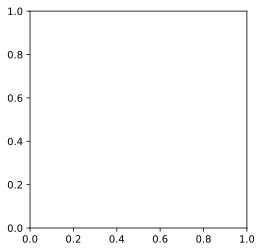

In [108]:
a = random.sample(train_tasks,5)
image_data = a[0]['support'][0]
print(image_data)
plt.imshow(image_data)

In [29]:
from torch.utils.data import DataLoader
model = Learner(config,3,32)
meta_iter = 500
meta_lr = 1e-3
meta_opt = torch.optim.SGD(model.parameters(), lr = 1e-3)
for i in range(meta_iter):    
    outer_loss = 0
    tasks = random.sample(train_tasks,5)
    for task in tasks:
        train_dataloader = DataLoader(task['support'], batch_size = 25, shuffle = True)
        test_dataloader = DataLoader(task['query'], batch_size = 5, shuffle = True)
        
        train_inputs, train_targets = iter(train_dataloader).next()
        
        train_classes_map = torch.unique(train_targets).tolist()

        map_ = {x: i for i, x in enumerate(train_classes_map)}
        
        train_targets = torch.tensor([map_[x.item()] for x in train_targets])
        train_inputs = torch.reshape(train_inputs,(25,3,32,32)).type(torch.FloatTensor)
        
        test_inputs, test_targets = iter(test_dataloader).next()

        test_inputs = torch.reshape(test_inputs,(5,3,32,32)).type(torch.FloatTensor)
        test_targets = torch.tensor([map_[x.item()] for x in test_targets])
        
        train_logits = model(train_inputs)
        inner_loss = F.cross_entropy(train_logits, train_targets)
#         print("Inner_loss: ",inner_loss)
        model.zero_grad()
        grad = torch.autograd.grad(inner_loss, model.parameters())
        fast_weights = list(map(lambda p: p[1] - meta_lr * p[0], zip(grad, model.parameters())))

        test_logits = model(test_inputs, fast_weights)
        outer_loss += F.cross_entropy(test_logits, test_targets)
    if(i % 100 ==0): print("Outer_loss: ",outer_loss)
    meta_opt.zero_grad()
    outer_loss.backward()
    meta_opt.step()

Outer_loss:  tensor(10.7057, grad_fn=<AddBackward0>)
Outer_loss:  tensor(0.4627, grad_fn=<AddBackward0>)
Outer_loss:  tensor(0.2431, grad_fn=<AddBackward0>)
Outer_loss:  tensor(0.1287, grad_fn=<AddBackward0>)
Outer_loss:  tensor(0.1144, grad_fn=<AddBackward0>)


### Fine Tune with one Step

[[array([[[155, 154, 134],
        [169, 168, 148],
        [178, 177, 157],
        ...,
        [156, 159, 139],
        [165, 168, 150],
        [170, 170, 149]],

       [[162, 163, 142],
        [171, 172, 151],
        [176, 177, 157],
        ...,
        [171, 171, 152],
        [175, 176, 159],
        [164, 163, 144]],

       [[170, 172, 151],
        [169, 172, 151],
        [169, 172, 151],
        ...,
        [170, 171, 151],
        [175, 176, 159],
        [159, 159, 139]],

       ...,

       [[132, 130, 106],
        [130, 125,  96],
        [140, 145, 117],
        ...,
        [140, 132,  96],
        [133, 139, 102],
        [147, 165, 125]],

       [[149, 148, 123],
        [122, 124,  94],
        [149, 166, 136],
        ...,
        [130, 133, 103],
        [130, 137, 109],
        [150, 166, 134]],

       [[167, 171, 152],
        [136, 142, 118],
        [137, 149, 120],
        ...,
        [158, 164, 137],
        [125, 130, 105],
        [121, 128, 100

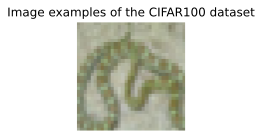

In [124]:
test_finetune_task = random.sample(test_tasks, 1)
print(test_finetune_task[0]['query'])
train_dataloader = DataLoader(test_finetune_task[0]['support'], batch_size = 25, shuffle = True)
test_dataloader = DataLoader(test_finetune_task[0]['query'], batch_size = 5, shuffle = True)
train_inputs_FT, train_targets_FT = iter(train_dataloader).next()
test_inputs_FT = torch.reshape(train_inputs_FT,(25,3,32,32)).type(torch.FloatTensor)


img_grid = torchvision.utils.make_grid(test_inputs_FT, nrow=5, normalize=True)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(2,2))
plt.title("Image examples of the CIFAR100 dataset")
plt.imshow(test_finetune_task[0]['query'][0][0])
plt.axis('off')
plt.show()
plt.close()

In [30]:
train_dataloader = DataLoader(test_finetune_task['support'], batch_size = 25, shuffle = True)
test_dataloader = DataLoader(test_finetune_task['query'], batch_size = 5, shuffle = True)


meta_iter_ft = 5
outer_loss = 0
meta_lr = 1e-2
meta_opt = torch.optim.SGD(model.parameters(), lr = 1e-2)
for i in range(meta_iter_ft):

    train_inputs, train_targets = iter(train_dataloader).next()
    train_classes_map = torch.unique(train_targets).tolist()
    map_ = {x: i for i, x in enumerate(train_classes_map)}

    train_targets = torch.tensor([map_[x.item()] for x in train_targets])
    train_inputs = torch.reshape(train_inputs,(25,3,32,32)).type(torch.FloatTensor)

    test_inputs, test_targets = iter(test_dataloader).next()

    test_inputs = torch.reshape(test_inputs,(5,3,32,32)).type(torch.FloatTensor)
    test_targets = torch.tensor([map_[x.item()] for x in test_targets])
    train_logits = model(train_inputs)
    inner_loss = F.cross_entropy(train_logits, train_targets)
    model.zero_grad()
    grad = torch.autograd.grad(inner_loss, model.parameters())
    fast_weights = list(map(lambda p: p[1] - meta_lr * p[0], zip(grad, model.parameters())))

    test_logits = model(test_inputs, fast_weights)
    outer_loss = F.cross_entropy(test_logits, test_targets)
    print(outer_loss)
    meta_opt.zero_grad()
    outer_loss.backward()
    meta_opt.step()

tensor(1.9835, grad_fn=<NllLossBackward>)
tensor(0.1087, grad_fn=<NllLossBackward>)
tensor(0.0606, grad_fn=<NllLossBackward>)
tensor(0.0452, grad_fn=<NllLossBackward>)
tensor(0.0355, grad_fn=<NllLossBackward>)


torch.Size([12, 3, 32, 32])
torch.Size([3, 70, 206])


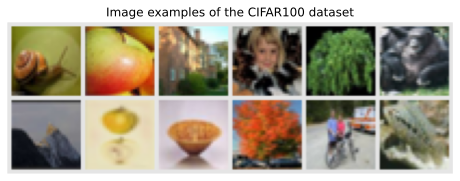

In [61]:
NUM_IMAGES = 12
CIFAR_images = torch.stack([CIFAR_train_set[np.random.randint(len(CIFAR_train_set))][0] for idx in range(NUM_IMAGES)], dim=0)
print(CIFAR_images.shape)
img_grid = torchvision.utils.make_grid(CIFAR_images, nrow=6, normalize=True, pad_value=0.9)
print(img_grid.shape)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("Image examples of the CIFAR100 dataset")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

torch.Size([3, 36, 172])


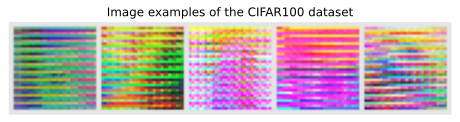

In [65]:
img_grid = torchvision.utils.make_grid(test_inputs, nrow=5, normalize=True, pad_value=0.9)
print(img_grid.shape)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("Image examples of the CIFAR100 dataset")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()